# Building a Deep Convolutional Neural Network from scratch

> Written by Dr Daniel Buscombe, Northern Arizona University

> Part of a series of notebooks for image recognition and classification using deep convolutional neural networks

## Preamble

This notebook is an introduction to building a convolutional neural network from scratch, for the purposes of binary image classification

## Objective

We're going to construct an CDNN to segment images into two classes: 'water' and 'not water'

### Load libraries

In [1]:
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 

import s3fs
fs = s3fs.S3FileSystem(anon=True)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

root = 'esipfed/cdi-workshop'

This time we'll also load the [contrib.layers](https://www.tensorflow.org/api_guides/python/contrib.layers) which are high level functions for building neural network layers

In [2]:
import random
np.random.seed(0)
from tensorflow.contrib.layers import conv2d, conv2d_transpose, batch_norm

## Model architecture

![](https://i.stack.imgur.com/lm5wv.png)

Convolutional layers apply a specified number of convolution filters to the image. For each subregion, the layer performs a set of mathematical operations to produce a single value in the output feature map. 

Then a ReLU activation function is applied to the output to introduce nonlinearities into the model.

Pooling layers downsample the image data extracted by the convolutional layers to reduce the dimensionality of the feature map in order to decrease processing time. Max pooling extracts subregions of the feature map, keeps their maximum value, and discards all other values.

### Convolution network architecture

1. Convolutional layer 1
2. Batch normalization
3. Pooling layer 1
4. Residual layer 1
5. Pooling layer 2
6. Residual layer 2
7. Pooling layer 3
8. Residual layer 3

The convolutional layer applies 32, 3x3 filters with a reLU activation function

![](https://www.kdnuggets.com/wp-content/uploads/activation.png)

In [3]:
def conv(T, num_kernels, kernel_size, activation_fn=tf.nn.relu): 
    """
    2d convolution
    """
    return conv2d(T, num_kernels, kernel_size, activation_fn=activation_fn)

What is batch normalization?
* Essentially, normalizing the input layer by adjusting and scaling the activations.

Why do we use batch normalization?

* Batch normalization allows each layer of a network to learn by itself a little bit more independently of other layers.

* We can use higher learning rates because batch normalization makes sure that there’s no activation that’s gone really high or really low. And by that, things that previously couldn’t get to train, it will start to train.

* It reduces overfitting because it has a slight regularization effects. Similar to dropout, it adds some noise to each hidden layer’s activations. Therefore, if we use batch normalization, we will use less dropout, which is a good thing because we are not going to lose a lot of information. 

In [4]:
def bn(T):
    """
    batch normalization
    """
    return batch_norm(T, updates_collections=None)

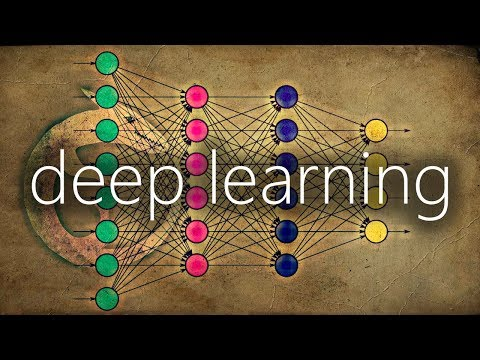

In [5]:
from IPython.display import YouTubeVideo
YouTubeVideo('dXB-KQYkzNU') ## 7 mins

Each residual layer consists of two sets of convolution followed by a batch normalization

![](https://cdn-images-1.medium.com/max/376/1*pUyst_ciesOz_LUg0HocYg.png)

In [6]:
def residual(T, num_kernels, kernel_size):
    T = conv(T, num_kernels, kernel_size)
    T = bn(T)
    T = conv(T, num_kernels, kernel_size, activation_fn=None)
    T = bn(T)
    return T

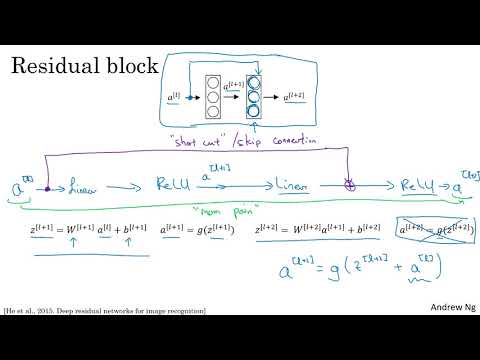

In [7]:
YouTubeVideo('ZILIbUvp5lk')

The pooling layer performs max. pooling with a 2x2 filter and stride of 2

In [8]:
def pool(T):
    """
    max pooling with no overlap
    """
    return tf.nn.max_pool(T, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

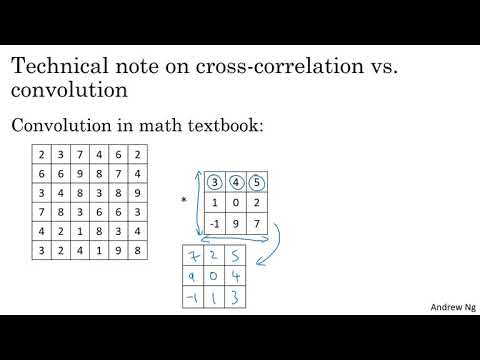

In [9]:
## strided convolutions
YouTubeVideo('tQYZaDn_kSg') ## 9 mins

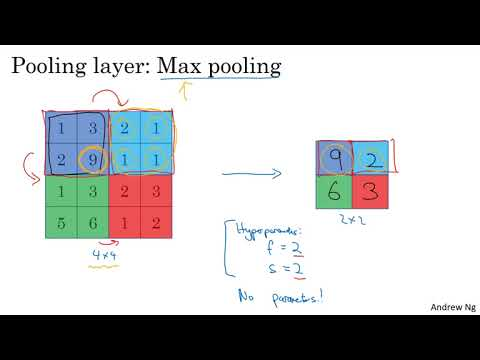

In [10]:
## pooling layers
YouTubeVideo('8oOgPUO-TBY') ## 10 mins

### Deconvolution network architecture

1. Unpooling layer 1
2. Transpose residual layer 1
3. Unpooling layer 2
4. Transpose residual layer 2
5. Unpooling layer 3
6. Transpose residual layer 3
7. Transpose convolution layer

An unpooling layer is a reverse convolution

In [11]:
def unpool(T):
    """
    inverse of pooling step
    """
    height, width = T.get_shape().as_list()[1:3]
    return tf.image.resize_images(T, (height*2, width*2))

Each transpose residual layer consists of two sets of transpose convolution and batch normalization

In [12]:
def residualT(T, num_kernels, kernel_size):
    T = convT(T, num_kernels, kernel_size)
    T = bn(T)
    T = convT(T, num_kernels, kernel_size, activation_fn=None)
    T = bn(T)
    return T

In [13]:
def convT(T, num_kernels, kernel_size, activation_fn=tf.nn.relu):
    """
    transpose of 2d convolution
    """
    return conv2d_transpose(T, num_kernels, kernel_size, activation_fn=activation_fn)

Utility functions

In [14]:
def gcd(a,b):
    """Compute the greatest common divisor of a and b"""
    while b > 0:
        a, b = b, a % b
    return a

def flatten(T):
    flat_size = np.prod(T.get_shape().as_list()[1:])
    return tf.reshape(T, [-1, flat_size])

Other functions for getting batches of images and masks, patches of pixels within images, and creating test and train data sets

In [15]:
## given an array of images and associated masks, choose one at random
def get_random_image_and_mask(images_and_masks):
    return random.choice(images_and_masks)

## get a randomly selected patch of pixels from an image, with given dimensions
def get_random_patch(images_and_masks, patch_height, patch_width):
    image, mask = get_random_image_and_mask(images_and_masks)
    
    image_height, image_width, image_channels = image.shape
    assert(image_channels == 3)
    
    x = np.random.randint(image_width - patch_width)
    y = np.random.randint(image_height - patch_height)
    
    image_patch = image[y:y+patch_height, x:x+patch_width]
    mask_patch  = mask [y:y+patch_height, x:x+patch_width]
    
    return image_patch, mask_patch

## select a random batch of images and masks
def get_random_batch(images_and_masks, batch_size, patch_height, patch_width):
    image_patches = []
    mask_patches = []
    
    for i in range(batch_size):
        image_patch, mask_patch = get_random_patch(images_and_masks, patch_height, patch_width)
        
        image_patches.append(image_patch)
        mask_patches.append(mask_patch)

    return image_patches, mask_patches

## create training and testing sets given user-specified split
def split_train_test(values, test_ratio = 0.2):
    # split [values] into [train values] + [test values]
    
    n = len(values)
    n_train = n - int(n*test_ratio)

    train = values[:n_train]
    test  = values[n_train:]
    
    return train, test

### Preparing a test and train data set

We'll load images in from the Lake Ontario dataset. This time we'll use every second image in both the 'test' and 'train' subfolders

In [16]:
image_files = [f for f in fs.ls(root+'/semseg_data/ontario/train') if f.endswith('.JPG')][::2]
image_files.extend([f for f in fs.ls(root+'/semseg_data/ontario/test') if f.endswith('.JPG')][::2])

# image scaling factor (we're going to reduce image size by a factor of 8, to speed up processing)
imsize = 0.125

# how many images do we have in total?
len(image_files)

24

Below we're reading and resizing each image one by one

In [17]:
from scipy.misc import imresize
from imageio import imread

images = []
for file in image_files:
    with fs.open(file, 'rb') as f:
        images.append(imresize(imread(f), imsize))

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:7: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Load in the classification data. There should be a ".mat" file associated with each of the images

In [18]:
class_files = [f for f in fs.ls(root+'/semseg_data/ontario/train') if f.endswith('.mat')][::2]
class_files.extend([f for f in fs.ls(root+'/semseg_data/ontario/test') if f.endswith('.mat')][::2])
len(class_files)

24

The classes are stored in .mat format. Water is class '2'

We load in each file, binarize it (water=0, not water=1), and resize it

In [19]:
from scipy.io import loadmat
classes = []
for file in class_files:
    #print("Working on %s" % file.split(os.sep)[-1])
    with fs.open(file, 'rb') as f:
        # load the 'class' key from the dictionary, and make a matrix consisting of 1 where there is no water, and zero where there is water
        tmp = (loadmat(f)['class']!=2).astype('uint8')
        # resize and make it a integer data type
        classes.append(imresize(tmp, imsize).astype('int'))

/opt/conda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


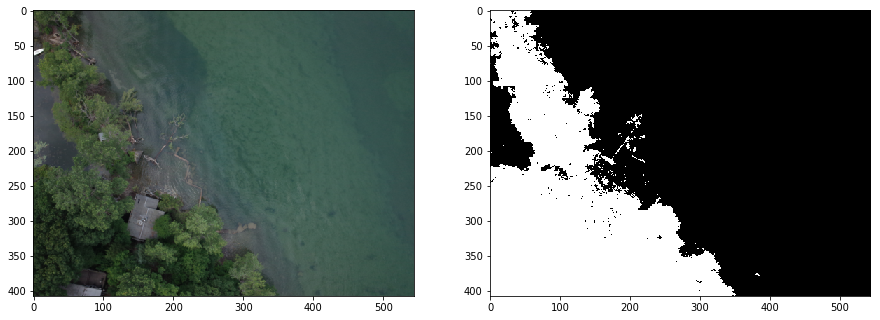

In [20]:
# make a plot of just the first image and mask (index = 0)
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(images[0])
# give the mask (water/no water) a black and white colormap
plt.subplot(122); plt.imshow(classes[0], cmap=plt.cm.binary_r)

Create a list of all images and masks together

We also ensure that both images and mask range over a scale 0 to 1

In [21]:
images_and_masks = []
for image, mask in zip(images, classes):
    images_and_masks.append((image.astype(np.float32)/255.0, mask.astype(np.float32)/255.0))

In [22]:
len(images_and_masks)

24

### Training function:

There is a lot of detail here, but essentially what it is doing is

1. Creates a tensorflow placeholder for image and mask patches. Those patches are smaller portions of images/masks that are used to train and validate the model

2. Sets up the model architecture by defining a series of sequential layers, and loss function

3. A for loop that cycles through ```n_batches```. Each cycle, a new random set of image and mask patches are used to train the model (update the weights and biases in the neural network)

4. A new random set of image and mask patches are used to test the updated model. The testing loss is printed to screen 

In [23]:
def train(patch_width, batch_size, kernel_size, num_kernels, n, n_batches, imsize, train_im_n_masks, test_im_n_masks):

   patch_height = patch_width

   image_patch_init = tf.placeholder(tf.float32, [None, patch_width, patch_height, 3])
   mask_patch_init  = tf.placeholder(tf.float32, [None, patch_width, patch_height, 1])

   # set up residual convolutional network architecture 
   T = image_patch_init
   T = conv(T, num_kernels, kernel_size) ##16
   T = bn(T)
    
   ##cycle through n pooling-residual steps
   for _ in range(n):
      T = pool(T)
      T += residual(T, num_kernels, kernel_size) ##16

   ##cycle through n unpooling-residual steps
   for _ in range(n):
      T = unpool(T)
      T += residualT(T, num_kernels, kernel_size) ##16
    
   T = convT(T, 1, kernel_size, activation_fn=None)

   pred_mask_patches = T

   ##l2 loss
   diff = tf.abs(pred_mask_patches - mask_patch_init)
   loss_fn = tf.reduce_mean(diff**2)

   # adam optimizer requires the least amount of work to train
   optimizer = tf.train.AdamOptimizer()
   trainer = optimizer.minimize(loss_fn)

   # make a tensorflow session
   sess = tf.InteractiveSession()

   # initialize weights and stuff
   initializer = tf.global_variables_initializer()
   sess.run(initializer)

   # train the model
   last_print_time = 0
   for batch in range(n_batches + 1):
      # make a batch of patches
      image_patches, mask_patches = get_random_batch(train_im_n_masks, batch_size, patch_height, patch_width)

      #deal with the possibility of empty patches
      ind = []
      for k in range(len(mask_patches)):
         if mask_patches[k].size==0: 
            ind.append(k)
 
      for x in ind[::-1]:
         del mask_patches[x]
         del image_patches[x]

      try:
         # feed it to the neural net
         feed_dict = {
           image_patch_init: image_patches,
           mask_patch_init: mask_patches,
         }
         _, train_loss = sess.run([trainer, loss_fn], feed_dict=feed_dict)

         # print training error every second
         time_since_last_print = time.clock() - last_print_time
         if time_since_last_print > 1.0:
            print("batch number =%5d, training loss =%f"%(batch, train_loss))
            last_print_time = time.clock()

         # check test error every 50 iterations
         if batch % 50 != 0: continue

         # check test loss
         image_patches, mask_patches = get_random_batch(test_im_n_masks, batch_size, patch_height, patch_width)

         #deal with the possibility of empty patches
         ind = []
         for k in range(len(mask_patches)):
            if mask_patches[k].size==0: 
               ind.append(k)

         for x in ind[::-1]:
            del mask_patches[x]
            del image_patches[x]

         feed_dict = {
           image_patch_init: image_patches,
           mask_patch_init: mask_patches,
         }
    
         test_loss = sess.run(loss_fn, feed_dict=feed_dict)

         print("#"*40)
         print("testing loss =%f"%test_loss)
         print("#"*40)

      except:
         pass

   # save the model
   saver = tf.train.Saver()

   tf.add_to_collection('loss', loss_fn)
   tf.add_to_collection('train', trainer)
   tf.add_to_collection('pred_mask_patches', pred_mask_patches)
   tf.add_to_collection('image_patch_init', image_patch_init)
   tf.add_to_collection('mask_patch_init', mask_patch_init)

   try:
      os.mkdir("model_"+str(imsize)+"_"+str(patch_width))
   except:
      pass

   saver.save(sess, "model_"+str(imsize)+"_"+str(patch_width)+os.sep+"model")
   sess.close()
   tf.reset_default_graph()
   del sess


### Train the model

we'll train with different patch widths and associated batch sizes

Options

In [24]:
n_batches  = 600 
# size of kernel in convolution
kernel_size = 3 
# number of kernels of size kernel_size x kernel_size
num_kernels = 16 
#number of pooling layers
n = 2 #3 

Split the data set into training and testing sets

In [25]:
train_im_n_masks, test_im_n_masks = split_train_test(images_and_masks, test_ratio=.2)
#del images_and_masks

In [26]:
print(len(train_im_n_masks))
print(len(test_im_n_masks))

20
4


What's the structure of this data?

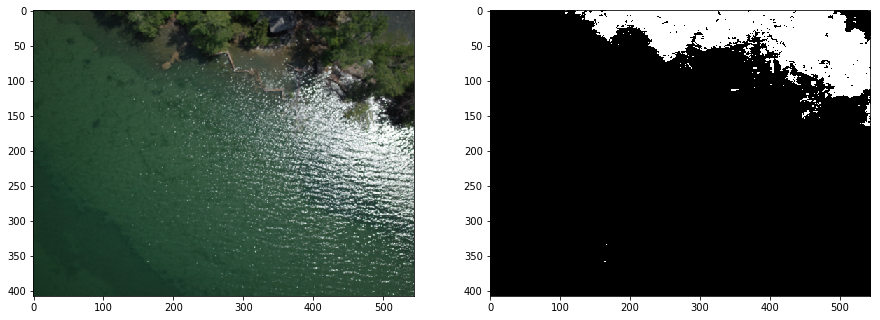

In [27]:
plt.figure(figsize=(15,10))
plt.subplot(121); plt.imshow(test_im_n_masks[0][0])
plt.subplot(122); plt.imshow(test_im_n_masks[0][1], cmap=plt.cm.binary_r)

Train using different patch widths. The idea here is that it is possible that the model performs best at a certain scale of input. By training the model several times, each with a differently sized patch, we should be able to either 1) identify the 'best' scale; or 2) aggregate results from multiple scales (using different models) into a single output

We specify an inverse relationship between the size of the patch and the number of patches

In [28]:
for patch_width in [16, 32, 64, 128, 256]:

   print("Processing: %i" % patch_width)
   if patch_width == 16:
      batch_size = 2000 #1000
   elif patch_width == 32:
      batch_size = 1000 #500
   elif patch_width == 64:
      batch_size = 500 #250   
   elif patch_width == 128:
      batch_size = 250 ##125
   elif patch_width == 256:
      batch_size = 125 ##125
        
   train(patch_width, batch_size, kernel_size, num_kernels, n, n_batches, imsize, train_im_n_masks, test_im_n_masks)

Processing: 16
Processing: 32
Processing: 64
Processing: 128
Processing: 256


### Test the model

First we need to create a function that uses the model to make the prediction

In [29]:
def make_pred(impad, height, width, kernel_size, num_patches, path):

   # load the model 
   sess = tf.Session() #InteractiveSession()
   new_saver = tf.train.import_meta_graph("./%s/model.meta"%path)
   new_saver.restore(sess, tf.train.latest_checkpoint('./%s/'%path))

   pred_mask_patches = tf.get_collection('pred_mask_patches')[0]
   image_patch_init = tf.get_collection('image_patch_init')[0]
   mask_patch_init = tf.get_collection('mask_patch_init')[0]

   patch_height = patch_width = kernel_size

   # Only the prediction at the center of a patch is correct
   # so we make a weight patch to weight the predicted mask patch appropriately.
   x = np.linspace(-1, +1, patch_width)
   y = np.linspace(-1, +1, patch_height)
   X, Y = np.meshgrid(x, y)
   dist = smoothstep(1.3, 0.3, np.sqrt(X*X + Y*Y))
   weight_patch = dist.reshape((patch_height, patch_width, 1))

   # take random patches from within the orig image bounds
   image_patches = []
   patch_pos = []
   for i in range(num_patches):
      x = np.random.randint(width  + patch_width) + width  - patch_width
      y = np.random.randint(height + patch_height) + height - patch_height
    
      image_patch = impad[y:y+patch_height, x:x+patch_width]
    
      image_patches.append(image_patch)
      patch_pos.append((y, x))

   # predict the object mask for those patches
   feed_dict = {image_patch_init: image_patches}
   mask_patches = sess.run(pred_mask_patches, feed_dict=feed_dict)

   sess.close()

   # stitch the object masks back together while weighting them
   pred_mask = np.zeros(impad.shape)
   weight = np.zeros(impad.shape)

   w = np.nanmedian(weight_patch)
   for mask_patch, p in zip(mask_patches, patch_pos):
      y, x = p

      mask_patch[mask_patch<0] = np.nan
      pred_mask[y:y+patch_height*2, x:x+patch_width*2, :] += np.nanmedian(mask_patch)*w
      weight[y:y+patch_height*2, x:x+patch_width*2, :] += w

   # only need first layers
   pred_mask = np.nanmean(pred_mask, axis=2)
   weight = np.nanmean(weight, axis=2)

   # normalize the masks by weight
   pred_mask /= weight + 0.001

   # extract just the center image 
   pred_mask = pred_mask[1*height:2*height, 1*width:2*width] #, :]

   tf.reset_default_graph()
   del sess
   P = pred_mask/np.nanmax(pred_mask)
   P[np.isnan(P)] = 0
   return P

In [30]:
##======================================================
def smoothstep(edge0, edge1, x):
    # https://www.opengl.org/sdk/docs/man/html/smoothstep.xhtml
    t = np.clip((x - edge0)/(edge1 - edge0), 0.0, 1.0)
    return t*t*(3.0 - 2.0*t)

Our first test will be with a mid-range kernel size of 32

In [31]:
kernel_size = 32
num_patches = 1000

patch_height = kernel_size

path = 'model_'+str(imsize)+'_'+str(kernel_size)

In [32]:
testimage = train_im_n_masks[0][0]

One more function! This one pads an image using mirroring, to minimize edge effects

In [33]:
def get_padded_image(testimage):
    height, width, n_channels = testimage.shape
    impad = np.zeros((height*3, width*3, n_channels))

    impad[1*height:2*height, 1*width:2*width, :] = testimage
    impad[0*height:1*height, 1*width:2*width, :] = np.flipud(testimage)
    impad[2*height:3*height, 1*width:2*width, :] = np.flipud(testimage)
    impad[1*height:2*height, 0*width:1*width, :] = np.fliplr(testimage)
    impad[1*height:2*height, 2*width:3*width, :] = np.fliplr(testimage)

    impad[0*height:1*height, 0*width:1*width, :] = np.flipud(np.fliplr(testimage))
    impad[2*height:3*height, 0*width:1*width, :] = np.flipud(np.fliplr(testimage))
    impad[0*height:1*height, 2*width:3*width, :] = np.flipud(np.fliplr(testimage))
    impad[2*height:3*height, 2*width:3*width, :] = np.flipud(np.fliplr(testimage))
    
    return height, width, impad

In [34]:
height, width, impad = get_padded_image(testimage)

Get a prediction:

In [35]:
P = make_pred(impad, height, width, kernel_size, num_patches, path)

INFO:tensorflow:Restoring parameters from ./model_0.125_32/model


Now we can plot to see the prediction

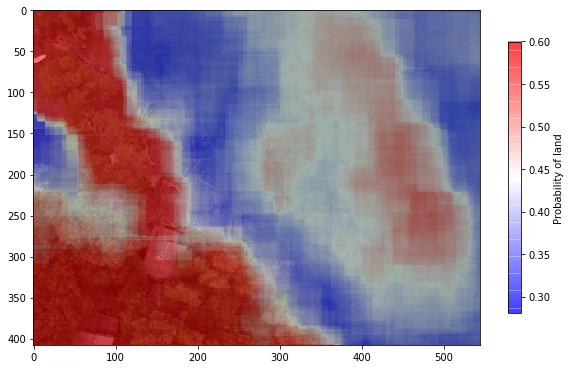

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(testimage)
plt.imshow(P, alpha=0.5, cmap=plt.cm.bwr, vmax=0.6)
cb = plt.colorbar(shrink=0.5)
cb.set_label('Probability of land')

Let's look at a few more:

We'll see that at one scale the results are pretty mixed

INFO:tensorflow:Restoring parameters from ./model_0.125_32/model
INFO:tensorflow:Restoring parameters from ./model_0.125_32/model
INFO:tensorflow:Restoring parameters from ./model_0.125_32/model
INFO:tensorflow:Restoring parameters from ./model_0.125_32/model


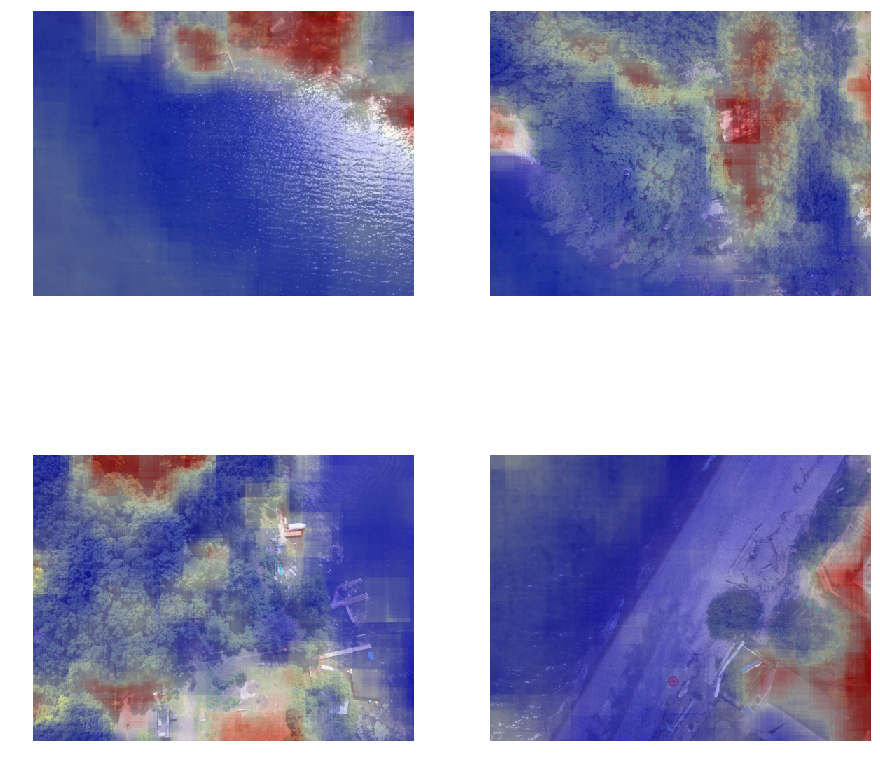

In [37]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, axi in enumerate(ax.flat):
    testimage = test_im_n_masks[i][0]
    height, width, impad = get_padded_image(testimage)
    P = make_pred(impad, height, width, kernel_size, num_patches, path)
    axi.imshow(testimage)
    axi.imshow(P, alpha=0.5, cmap=plt.cm.bwr)
    axi.axis('off')

### Multi-scalar prediction

Since we trained at multiple scales, we can also test at those scales and merged predictions

In [38]:
##testimage = test_im_n_masks[1][0]
testimage = train_im_n_masks[0][0]

height, width, impad = get_padded_image(testimage)

kernel_size = [16, 32, 64, 128, 256]

num_patches = [1000, 500, 250, 125, 64]

patch_height = np.min(kernel_size)

Run the model for all kernel sizes

In [39]:
P = []
for n in range(len(kernel_size)):
    path = 'model_'+str(imsize)+'_'+str(kernel_size[n])
    P.append(make_pred(impad, height, width, kernel_size[n], num_patches[n], path))

for n in range(len(kernel_size)):
    P[n][P[n]==0] = np.nan

INFO:tensorflow:Restoring parameters from ./model_0.125_16/model
INFO:tensorflow:Restoring parameters from ./model_0.125_32/model
INFO:tensorflow:Restoring parameters from ./model_0.125_64/model
INFO:tensorflow:Restoring parameters from ./model_0.125_128/model
INFO:tensorflow:Restoring parameters from ./model_0.125_256/model


Let's take a look at the outputs:

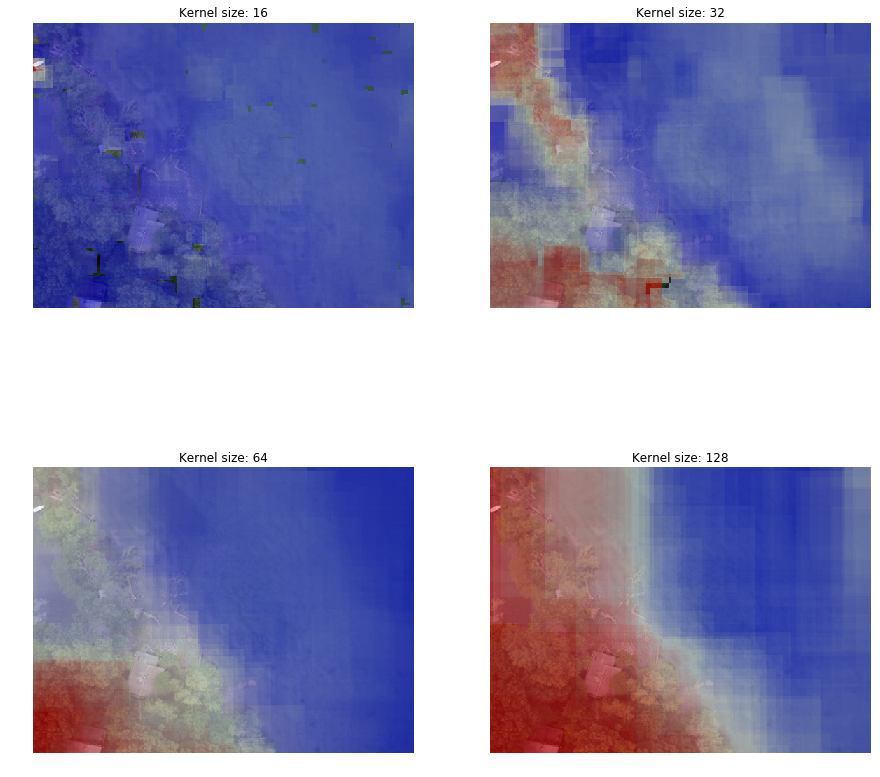

In [40]:
fig, ax = plt.subplots(2, 2)
fig.set_figheight(15)
fig.set_figwidth(15)
for i, axi in enumerate(ax.flat):
    axi.imshow(testimage)
    axi.imshow(P[i], alpha=0.5, cmap=plt.cm.bwr)
    axi.axis('off')
    axi.set(title='Kernel size: '+str(kernel_size[i]))

Compute a mean per pixel through the stack

In [41]:
pred = np.nanmean(np.dstack(P[1:]), axis=2)

In [42]:
# =========================================================
def rescale(dat,mn,mx):
    '''
    rescales an input dat between mn and mx
    '''
    m = min(dat.flatten())
    M = max(dat.flatten())
    return (mx-mn)*(dat-m)/(M-m)+mn

In [43]:
pred = rescale(pred, 0, 1)

Let's plot

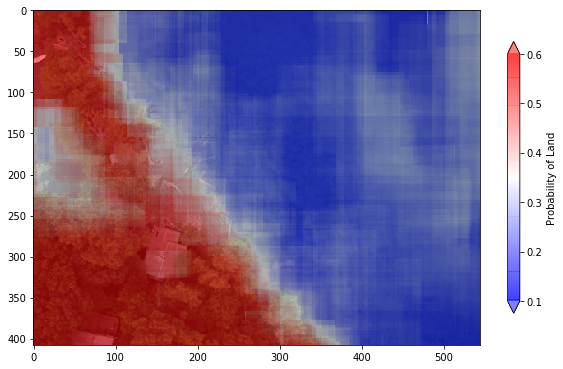

In [44]:
plt.figure(figsize=(10,10))
plt.imshow(testimage)
plt.imshow(pred, alpha=0.5, cmap=plt.cm.bwr, vmin=0.1, vmax=0.6)
cb = plt.colorbar(shrink=0.5, extend = 'both')
cb.set_label('Probability of Land')

### Creating the mask

So now we have a 'probability of land' map, we need to make a land/noland mask. What's the best strategy?

#### Global threshold

The simplest way would be to define a global threshold:

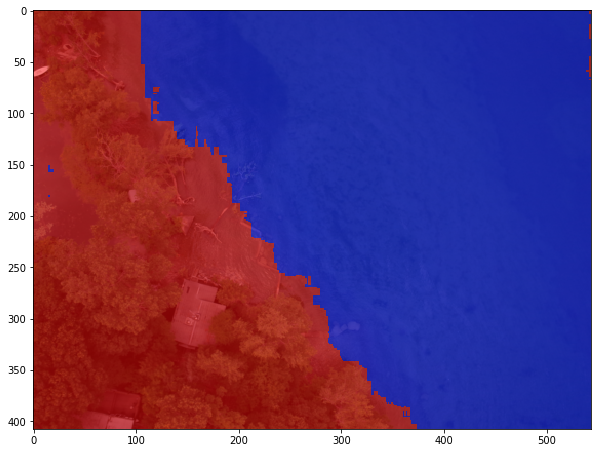

In [45]:
plt.figure(figsize=(10,10))
plt.imshow(testimage)
plt.imshow(pred>.3, alpha=0.5, cmap=plt.cm.bwr)
cb.set_label('Land')

This isn't optimal, and probably wouldn't generalize well

#### Generative

Another option is to use a generative ML algorithm to model the likelihood of the 2 classes

Let's use a Gaussian Mixture model, which is something we have used before. The following function will read the image and associated land probability, and fit a N component GMM

N could equal 2, or more

In [46]:
from sklearn import mixture

##======================================================
def GMM(im1, im, numclusters, maxiter):
   """
   takes an RGB image and a probability layer and computes
   an N-component (4-dimensional) Gaussian mixture model
   then recasts predictions in a 2D, N-component label map
   """
   
   X = np.c_[im1.flatten(), im[:,:,0].flatten(), im[:,:,1].flatten(), im[:,:,2].flatten()] 

   # Fit a Gaussian mixture
   dpgmm = mixture.GaussianMixture(n_components=numclusters, covariance_type='full', max_iter=maxiter).fit(X) 
   Yb = dpgmm.predict(X)
   return  Yb.reshape(im.shape[0], im.shape[1])##, probs.reshape(im.shape[0], im.shape[1],numclusters)

As an example, below we fit a 5-component GMM, similar to what we did on Day 1

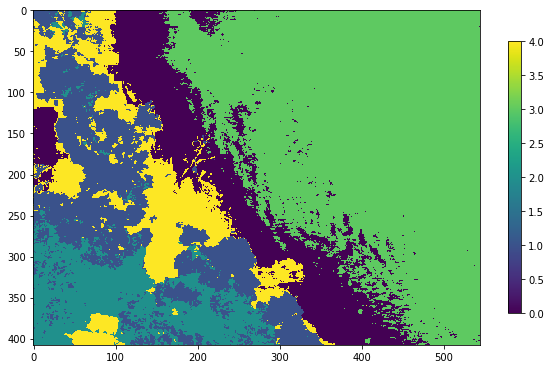

In [47]:
numclusters = 5 #number of clusters for GMM
maxiter = 50 #maximum iterations in GMM

p = GMM(pred, testimage, numclusters, maxiter)

plt.figure(figsize=(10,10))
plt.imshow(p)
plt.colorbar(shrink=0.5)

This function below will compute the median probability associated with each component, then mask the probabilities less than a specified threshold

In [ ]:
##======================================================
def GMM_mask_multi(pred_mask, image, maxiter, patch_height, prob_thres, numclusters):
   """
   implements GMM with nan replacement and checks on outputs
   """

   pred_mask[np.isinf(pred_mask)] = np.nanmean(pred_mask)
   pred_mask[np.isnan(pred_mask)] = np.nanmean(pred_mask)

   p = GMM(pred_mask, image, numclusters, maxiter)

   c = [np.nanmedian(pred_mask[p==k]) for k in range(numclusters)]

   if (np.all(np.asarray(c)>prob_thres) or np.all(np.asarray(c)<prob_thres)):
      prob_thres = np.mean(c)
      print("Revising probability threshold to %f"%prob_thres)

   mask = np.zeros(np.shape(p))
   for val in np.where(np.asarray(c)>prob_thres)[0]:
      mask[p==val] = 1

   return mask

In [ ]:
prob_thres = 0.3 #greater than this is kept in multi-part GMM

In [ ]:
p = GMM_mask_multi(pred, testimage, maxiter, patch_height, prob_thres, numclusters)

In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(testimage)
plt.imshow(p, alpha=0.5, cmap=plt.cm.bwr)
cb.set_label('Land')

Looks good, but it is still dependent on the ```prob_thres``` parameter. So the next step would be to be to analyse all the test images and see how well that parameter generalizes to the entire dataset